*texte en italique*#Import Libraries

In [ ]:
!pip install catboost

In [ ]:
!pip install skforecast

In [ ]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from skforecast.ForecasterAutoreg import ForecasterAutoreg
#from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.preprocessing import MinMaxScaler

from joblib import dump, load

# Configuration
# ==============================================================================
import warnings
#warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Downloading data

In [ ]:
# Downloading data
# ==============================================================================
url = ('//content/drive/MyDrive/dataPFE/Dataset_PV_corrected.csv')
data = pd.read_csv(url,sep=',')
data


,datetime,power,temperature,humidity,irradiation,wind_speed,pressure,cell_temperature
0,2022-02-25 00:00:00,1.161628,11.2,86.0,0.0,1.4,1022.7,9.724800
1,2022-02-25 00:05:00,0.879583,11.1,86.0,0.0,1.3,1022.7,9.724800
2,2022-02-25 00:10:00,0.535615,11.1,86.0,0.0,1.5,1022.7,9.650364
3,2022-02-25 00:15:00,0.825301,11.0,86.0,0.0,1.2,1022.8,9.658818
4,2022-02-25 00:20:00,0.990966,11.0,87.0,0.0,1.0,1022.8,9.621550
...,...,...,...,...,...,...,...,...
59054,2022-09-27 23:35:00,3.200000,21.4,72.0,0.0,2.9,1014.7,20.000000
59055,2022-09-27 23:40:00,3.200000,21.6,71.0,0.0,5.5,1015.0,20.125000
59056,2022-09-27 23:45:00,3.200000,21.7,70.0,0.0,5.0,1014.8,20.312000
59057,2022-09-27 23:50:00,3.200000,21.6,71.0,0.0,5.5,1014.8,20.250000


# Normalizig Data

In [ ]:
# drop the columns you want to delete
data.drop(['temperature',	'humidity','irradiation',	'wind_speed',	'pressure',	'cell_temperature'], axis=1, inplace=True)

In [ ]:
# import pandas and MinMaxScaler
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# get the columns to scale (excluding datetime)
columns_to_scale = data.columns.drop('datetime')

# create a MinMaxScaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# scale the data
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])


In [ ]:
# check the head of the scaled data
data.head()

,datetime,power
0,2022-02-25 00:00:00,0.000500
1,2022-02-25 00:05:00,0.000379
2,2022-02-25 00:10:00,0.000231
3,2022-02-25 00:15:00,0.000356
4,2022-02-25 00:20:00,0.000427


In [ ]:
# check the head of the scaled data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59059 entries, 0 to 59058
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  59059 non-null  object 
 1   power     59059 non-null  float64
dtypes: float64(1), object(1)
memory usage: 922.9+ KB


In [ ]:
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('datetime')
data = data[~data.index.duplicated(keep='first')] # drop duplicates
data = data.asfreq('5min')
data = data.sort_index()
data

,power
datetime,
2022-02-25 00:00:00,0.000500
2022-02-25 00:05:00,0.000379
2022-02-25 00:10:00,0.000231
2022-02-25 00:15:00,0.000356
2022-02-25 00:20:00,0.000427
...,...
2022-09-27 23:35:00,0.001379
2022-09-27 23:40:00,0.001379
2022-09-27 23:45:00,0.001379


In [ ]:
# Aggregating in 1H intervals
# ==============================================================================
# The Date column is eliminated so that it does not generate an error when aggregating.
# The Holiday column does not generate an error since it is Boolean and is treated as 0-1.
#data = data.drop(columns='Date')
data = data.resample(rule='H', closed='left', label ='right').mean()
data

,power
datetime,
2022-02-25 01:00:00,0.000294
2022-02-25 02:00:00,0.000657
2022-02-25 03:00:00,0.000915
2022-02-25 04:00:00,0.000318
2022-02-25 05:00:00,0.000586
...,...
2022-09-27 20:00:00,0.001328
2022-09-27 21:00:00,0.001336
2022-09-27 22:00:00,0.001314


# Split the data

In [ ]:
import pandas as pd
import numpy as np

# Define the start and end dates of the data
#start_date = '2022-02-25 01:00:00'
#end_date = '2022-09-28 00:00:00'

# Create a DatetimeIndex for the entire date range
#dt_index = pd.date_range(start=start_date, end=end_date, freq='1H')

# Create a dataframe with the DatetimeIndex as the index
#data = pd.DataFrame(index=dt_index)

# Split the data into train, validation, and test sets
#train_size = int(len(data) * 0.6)
#val_size = int(len(data) * 0.2)
#test_size = len(data) - train_size - val_size

#train_data = data.iloc[:train_size]
#val_data = data.iloc[train_size:train_size+val_size]
#test_data = data.iloc[train_size+val_size:]

#Print the start and end dates for each set
#print('Train data: Start Date:', train_data.index[0], ', End Date:', train_data.index[-1])
#print('Validation data: Start Date:', val_data.index[0], ', End Date:', val_data.index[-1])
#print('Test data: Start Date:', test_data.index[0], ', End Date:', test_data.index[-1])


In [ ]:
# Split train-val-test
# ==============================================================================
end_train = '2022-07-04 00:00:00'
end_validation = '2022-08-16 00:00:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2022-02-25 01:00:00 --- 2022-07-04 00:00:00  (n=3096)
Dates validacion : 2022-07-04 00:00:00 --- 2022-08-16 00:00:00  (n=1033)
Dates test       : 2022-08-16 00:00:00 --- 2022-09-28 00:00:00  (n=1033)


#Data exploration

**Plot time series**

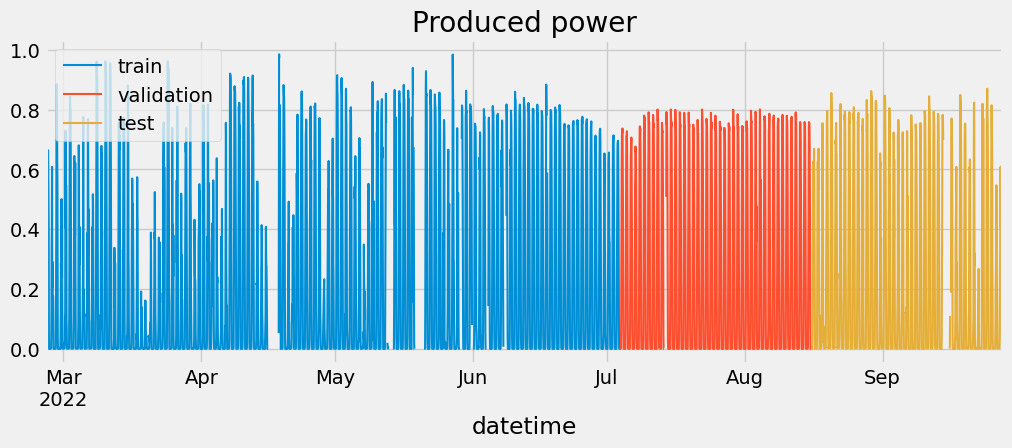

In [ ]:
# Plot time series
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
data_train['power'].plot(ax=ax, label='train')
data_val['power'].plot(ax=ax, label='validation')
data_test['power'].plot(ax=ax, label='test')
ax.set_title('Produced power')
ax.legend();

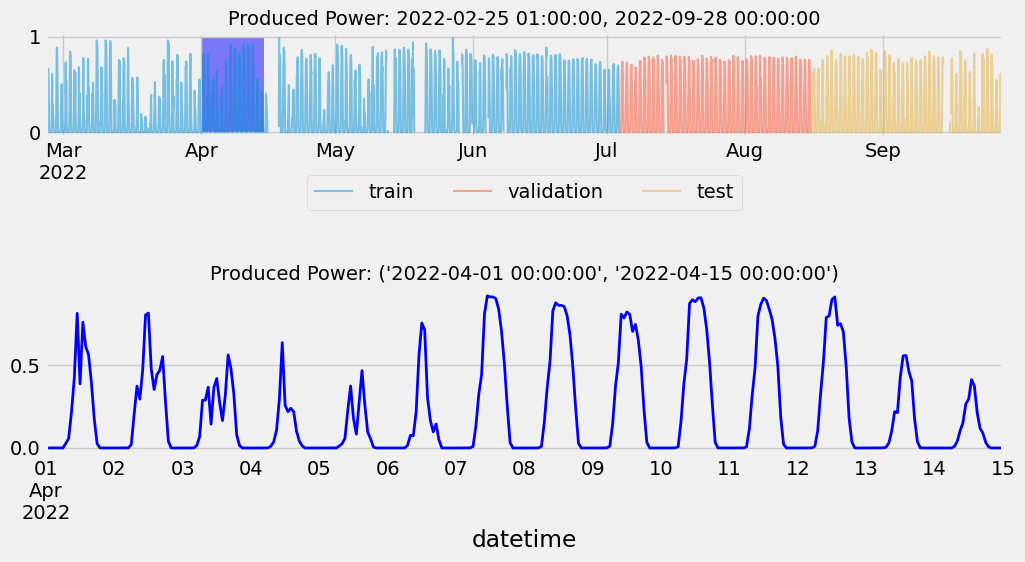

In [ ]:
#  Plot time series with zoom
# ==============================================================================
zoom = ('2022-04-01 00:00:00','2022-04-15 00:00:00')

fig = plt.figure(figsize=(11, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

data_train['power'].plot(ax=main_ax, label='train', alpha=0.5)
data_val['power'].plot(ax=main_ax, label='validation', alpha=0.5)
data_test['power'].plot(ax=main_ax, label='test', alpha=0.5)
min_y = min(data['power'])
max_y = max(data['power'])
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
main_ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.8))

data.loc[zoom[0]: zoom[1]]['power'].plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Produced Power: {data.index.min()}, {data.index.max()}', fontsize=14)
zoom_ax.set_title(f'Produced Power: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)

In [ ]:
# Interactive plot of time series
# ==============================================================================
data.loc[:end_train, 'partition'] = 'train'
data.loc[end_train:end_validation, 'partition'] = 'validation'
data.loc[end_validation:, 'partition'] = 'test'

fig = px.line(
    data_frame = data.reset_index(),
    x      = 'datetime',
    y      = 'power',
    color  = 'partition',
    title  = 'Produced Power',
    width  = 900,
    height = 500
)

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

data=data.drop(columns='partition')

NameError: ignored

#XGBoost

In [ ]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 24
                )

forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous 

# **Hyperparameter tuning (tuning)**

In [ ]:
print(data.loc[:end_validation, 'power'].isnull().sum())


195


In [ ]:
y = data.loc[:end_validation, 'power'].fillna(data.loc[:end_validation, 'power'].mean())
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }

# Lags used as predictors
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]


results_grid = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = y, # Train and validation data
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        steps              = 24,
        refit              = False,
        metric             = 'mean_squared_error',
        initial_train_size = int(len(data_train)), # Model is trained with trainign data
        fixed_train_size   = False,
        return_best        = True,
        verbose            = False
        )


Number of models compared: 48.


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [05:01<00:00, 75.45s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 71 72 73] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 0.00447648626363376



In [ ]:
# Results of grid search
# ==============================================================================
results_grid.head(10)

,lags,params,mean_squared_error,learning_rate,max_depth,n_estimators
42,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.004476,0.10,3.0,100.0
37,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.004599,0.01,3.0,500.0
39,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.005120,0.01,5.0,500.0
43,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.005148,0.10,3.0,500.0
44,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.005840,0.10,5.0,100.0
45,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.006171,0.10,5.0,500.0
47,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.007609,0.10,10.0,500.0
32,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.008128,0.10,5.0,100.0
46,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.008301,0.10,10.0,100.0
25,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.013451,0.01,3.0,500.0


In [ ]:
y_val = data_val['power']
X_val = data_test['power']
X_train = data_train.drop('power', axis=1)
y_train = data_train['power']
X_test = data_test.drop('power', axis=1)
y_test = data_test['power']


In [ ]:
data_test

,power
datetime,
2022-08-16 00:00:00,0.000000
2022-08-16 01:00:00,0.000153
2022-08-16 02:00:00,0.000160
2022-08-16 03:00:00,0.000176
2022-08-16 04:00:00,0.000323
...,...
2022-09-27 20:00:00,0.001328
2022-09-27 21:00:00,0.001336
2022-09-27 22:00:00,0.001314


**Backtesting test period**

In [ ]:
data['power'] = data['power'].fillna(method='ffill')


In [ ]:
# Backtesting test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = data['power'],
    initial_train_size = len(data.loc[:end_validation]),
    fixed_train_size   = False,
    steps      = 24,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
    )

print(f"Backtest error: {metric}")

Backtest error: 0.02657032973924148


In [ ]:
predictions

,pred
2022-08-16 01:00:00,0.000750
2022-08-16 02:00:00,0.000750
2022-08-16 03:00:00,0.000750
2022-08-16 04:00:00,0.000750
2022-08-16 05:00:00,0.001111
...,...
2022-09-27 20:00:00,0.006471
2022-09-27 21:00:00,0.005516
2022-09-27 22:00:00,0.006074
2022-09-27 23:00:00,0.006074


# Pred VS test

In [ ]:
pred_inverse= scaler.inverse_transform(predictions)

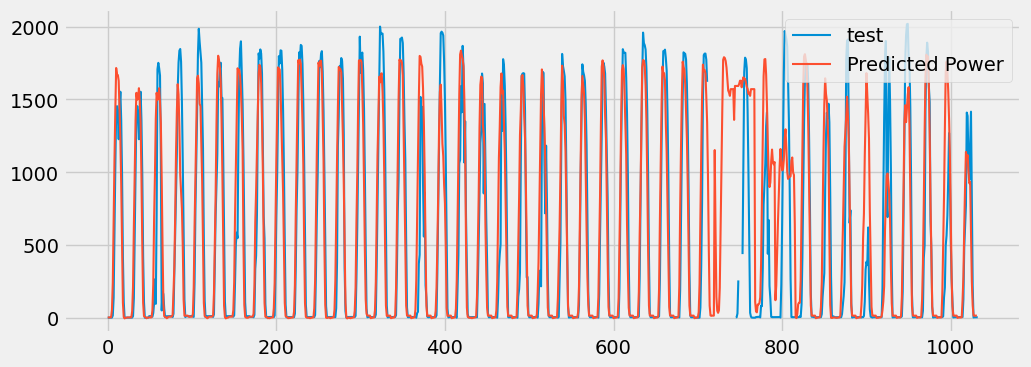

In [ ]:
# convert predictions to Series
pred_series = pd.Series(scaler.inverse_transform(predictions).reshape(-1))
new_test = pd.Series(scaler.inverse_transform(data_test).reshape(-1))

# plot actual and predicted values
fig, ax = plt.subplots(figsize=(11, 4))
new_test.plot(ax=ax, label = 'test')
pred_series.plot(ax=ax, label='Predicted Power')
ax.legend();



In [ ]:
import plotly.graph_objs as go

# convert predictions to Series
pred_series = pd.Series(scaler.inverse_transform(predictions).reshape(-1))
new_test = pd.Series(scaler.inverse_transform(data_test).reshape(-1))

# create a trace for actual power values
trace1 = go.Scatter(
    x = data_test.index,
    y = new_test,
    mode = 'lines',
    name = 'Actual Power'
)

# create a trace for predicted power values
trace2 = go.Scatter(
    x = data_test.index,
    y = pred_series,
    mode = 'lines',
    name = 'Predicted Power'
)


# define the layout of the plot
layout = go.Layout(
    title = 'Actual vs Predicted Power',
    xaxis = dict(title = 'Datetime'),
    yaxis = dict(title = 'Power (MW)'),
    hovermode = 'x unified'
)

# create the plot and show it
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()


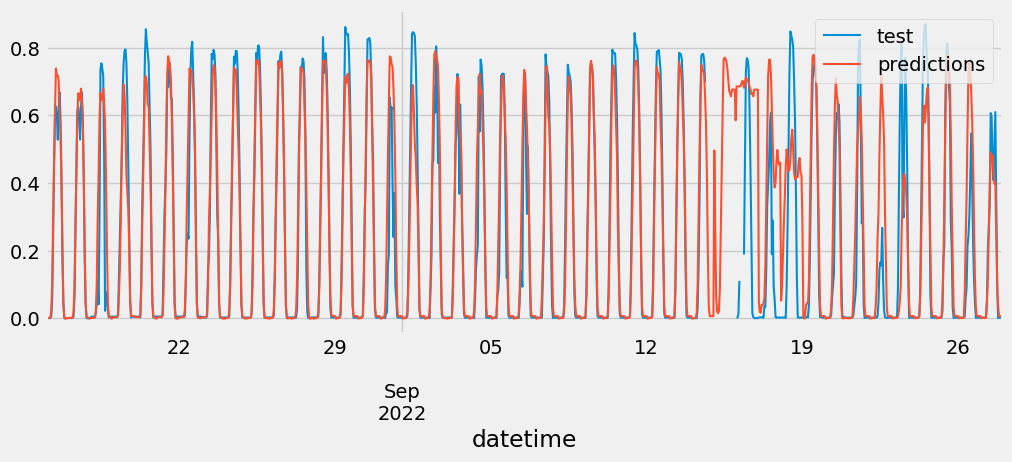

In [ ]:
# Plot of predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
data_test['power'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
# Interactive plot of predictions
# ==============================================================================
data_plot = pd.DataFrame({
                'test': data_test['power'],
                'prediction': predictions['pred'],
                 })
data_plot.index.name = 'datetime'

fig = px.line(
        data_frame = data_plot.reset_index(),
        x      = 'datetime',
        y      = data_plot.columns,
        title  = 'Produced Power',
        width  = 900,
        height = 500
      )

fig.update_xaxes(rangeslider_visible=True)
fig.show()

# Exogenous variables

In [ ]:
# Store categorical variables as category type
# ==============================================================================
data['temperature'] = data['temperature'].astype('category')
data['humidity']   = data['humidity'].astype('category')
data['irradiation'] = data['irradiation'].astype('category')

In [ ]:
# One hot encoding
# ==============================================================================
data = pd.get_dummies(data, columns=['temperature', 'humidity', 'irradiation'])
data.head(3)

,wind_speed,pressure,cell_temperature,power,temperature_0.0,temperature_0.0059559757595951624,temperature_0.026343738936670913,temperature_0.032757866677773397,temperature_0.04444074220621003,temperature_0.04856411003977594,...,irradiation_0.9747695515399808,irradiation_0.9761138342234251,irradiation_0.9778696320140463,irradiation_0.9790950325554173,irradiation_0.979259638598288,irradiation_0.9801924061745555,irradiation_0.9806039212817323,irradiation_0.984389860267759,irradiation_0.9882398127149024,irradiation_1.0
datetime,,,,,,,,,,,,,,,,,,,,,
2022-03-01 01:00:00,0.068809,0.777863,0.053493,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-03-01 02:00:00,0.073074,0.775827,0.058410,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-03-01 03:00:00,0.054023,0.773282,0.049661,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Select exogenous variables, including those generated by one hot encoding.
exog_variables = [column for column in data.columns
                      if column.startswith(('temperature', 'humidity', 'irradiation'))]
exog_variables.extend(['wind_speed',	'pressure',	'cell_temperature'])
exog_variables

['temperature_0.0',
 'temperature_0.0059559757595951624',
 'temperature_0.026343738936670913',
 'temperature_0.032757866677773397',
 'temperature_0.04444074220621003',
 'temperature_0.04856411003977594',
 'temperature_0.04879318603052959',
 'temperature_0.049376288552447974',
 'temperature_0.0542910098086174',
 'temperature_0.056581769716153994',
 'temperature_0.05841437764218332',
 'temperature_0.061163289531227204',
 'temperature_0.06162144151273452',
 'temperature_0.0636831254295175',
 'temperature_0.06391220142027114',
 'temperature_0.06414127741102481',
 'temperature_0.06482850538328577',
 'temperature_0.06528665736479312',
 'temperature_0.06574480934630042',
 'temperature_0.0664320373185614',
 'temperature_0.06711926529082239',
 'temperature_0.06849372123534432',
 'temperature_0.06872279722609802',
 'temperature_0.0698681771798663',
 'temperature_0.07536600095795412',
 'temperature_0.07628230492096878',
 'temperature_0.07811491284699806',
 'temperature_0.07880214081925903',
 'tem

# LightGBM

In [ ]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags = 24
             )

forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2023-05-12 09:38:28 
Last fit date: None 
Skforecast version: 0.7.0 
Python version: 3.10.11 
Forecaster id: 

In [ ]:
y = data.loc[:end_validation, 'power'].fillna(data.loc[:end_validation, 'power'].mean())


In [ ]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = y,
                        #exog               = data.loc[:end_validation, exog_variables],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 24,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
              )

Number of models compared: 24.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:25<00:00, 12.74s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 0.002535781376573284



In [ ]:
# Results grid search
# ==============================================================================
results_grid.head(10)

,lags,params,mean_squared_error,learning_rate,max_depth,n_estimators
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.002536,0.10,10.0,100.0
18,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.003239,0.10,3.0,100.0
13,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.003515,0.01,3.0,500.0
19,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.003620,0.10,3.0,500.0
20,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.003838,0.10,5.0,100.0
21,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.004704,0.10,5.0,500.0
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.004790,0.10,3.0,500.0
22,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.004850,0.10,10.0,100.0
15,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.005508,0.01,5.0,500.0
17,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.005748,0.01,10.0,500.0


In [ ]:
# Backtesting test data
# ==============================================================================
metric, pred_light = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = data['power'],
                        #exog               = data[exog_variables],
                        initial_train_size = len(data.loc[:end_validation]),
                        fixed_train_size   = False,
                        steps              = 24,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        verbose            = False
                      )

print(f"Backtest error: {metric}")

Backtest error: 0.02243805529409426


In [ ]:
# Feature importance
# ==============================================================================
impotance = forecaster.get_feature_importance()
impotance

,feature,importance
0,lag_1,287
1,lag_2,64
2,lag_3,51
3,lag_4,41
4,lag_5,55
...,...,...
67,lag_68,22
68,lag_69,36
69,lag_70,58
70,lag_71,56


In [ ]:
pred_light

,pred
2022-08-16 01:00:00,0.000312
2022-08-16 02:00:00,0.000312
2022-08-16 03:00:00,0.000433
2022-08-16 04:00:00,0.000433
2022-08-16 05:00:00,0.000521
...,...
2022-09-27 20:00:00,-0.000027
2022-09-27 21:00:00,0.000104
2022-09-27 22:00:00,0.000104
2022-09-27 23:00:00,0.000104


In [ ]:
pred_inverse= scaler.inverse_transform(pred_light)

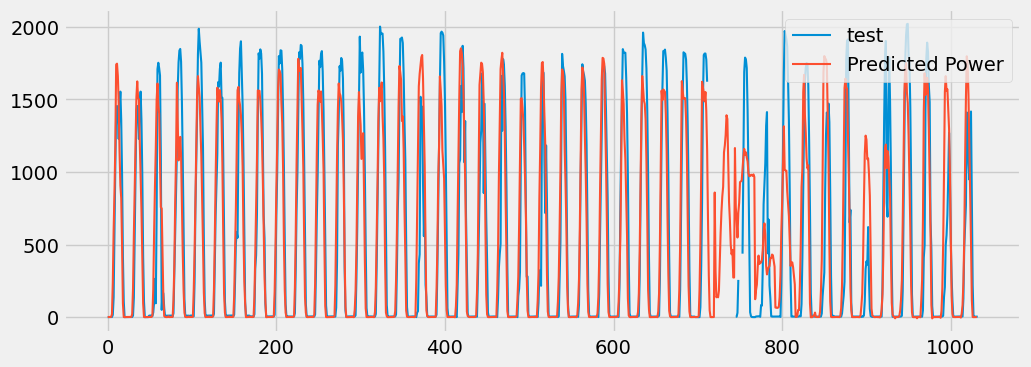

In [ ]:
# convert predictions to Series
pred_series = pd.Series(scaler.inverse_transform(pred_light).reshape(-1))
new_test = pd.Series(scaler.inverse_transform(data_test).reshape(-1))

# plot actual and predicted values
fig, ax = plt.subplots(figsize=(11, 4))
new_test.plot(ax=ax, label = 'test')
pred_series.plot(ax=ax, label='Predicted Power')
ax.legend();



In [ ]:
import plotly.graph_objs as go

# convert predictions to Series
pred_series = pd.Series(scaler.inverse_transform(pred_light).reshape(-1))
new_test = pd.Series(scaler.inverse_transform(data_test).reshape(-1))

# create a trace for actual power values
trace1 = go.Scatter(
    x = data_test.index,
    y = new_test,
    mode = 'lines',
    name = 'Actual Power'
)

# create a trace for predicted power values
trace2 = go.Scatter(
    x = data_test.index,
    y = pred_series,
    mode = 'lines',
    name = 'Predicted Power'
)


# define the layout of the plot
layout = go.Layout(
    title = 'Actual vs Predicted Power',
    xaxis = dict(title = 'Datetime'),
    yaxis = dict(title = 'Power (MW)'),
    hovermode = 'x unified'
)

# create the plot and show it
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()


# CatBoost

In [ ]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = CatBoostRegressor(random_state=123, silent=True),
                lags = 24
             )

forecaster

ForecasterAutoreg 
Regressor: <catboost.core.CatBoostRegressor object at 0x7f86a2ea1420> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'loss_function': 'RMSE', 'silent': True, 'random_state': 123} 
Creation date: 2023-05-12 09:08:25 
Last fit date: None 
Skforecast version: 0.7.0 
Python version: 3.10.11 
Forecaster id: None 

In [ ]:
y = data.loc[:end_validation, 'power'].fillna(data.loc[:end_validation, 'power'].mean())

# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = y,
                        #exog               = data.loc[:end_validation, exog_variables],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 24,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 24.


loop lags_grid: 100%|██████████████████████████████████████| 2/2 [04:36<00:00, 138.18s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 71 72 73] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 0.002544170368042774



In [ ]:
# Results grid search
# ==============================================================================
results_grid.head(10)

,lags,params,mean_squared_error,learning_rate,max_depth,n_estimators
22,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.002544,0.10,10.0,100.0
17,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.002660,0.01,10.0,500.0
20,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.002795,0.10,5.0,100.0
15,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.002808,0.01,5.0,500.0
18,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.003196,0.10,3.0,100.0
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.003256,0.01,5.0,500.0
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.003377,0.10,3.0,100.0
13,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.003493,0.01,3.0,500.0
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.003592,0.10,3.0,500.0
19,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.003628,0.10,3.0,500.0


In [ ]:
# Backtesting test data
# ==============================================================================
metric, pred = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data['power'],
                            #exog               = data[exog_variables],
                            initial_train_size = len(data.loc[:end_validation]),
                            fixed_train_size   = False,
                            steps              = 24,
                            refit              = False,
                            metric             = 'mean_squared_error',
                            verbose            = False
                       )

print(f"Backtest error: {metric}")

Backtest error: 0.02821465793729185


In [ ]:
# Interactive plot of predictions
# ==============================================================================
data_plot = pd.DataFrame({
                'test': data_test['power'],
                'prediction': predictions['pred'],
                 })
data_plot.index.name = 'datetime'

fig = px.line(
        data_frame = data_plot.reset_index(),
        x      = 'datetime',
        y      = data_plot.columns,
        title  = 'Produced Power',
        width  = 900,
        height = 500
      )

fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [ ]:
pred_inverse= scaler.inverse_transform(pred)

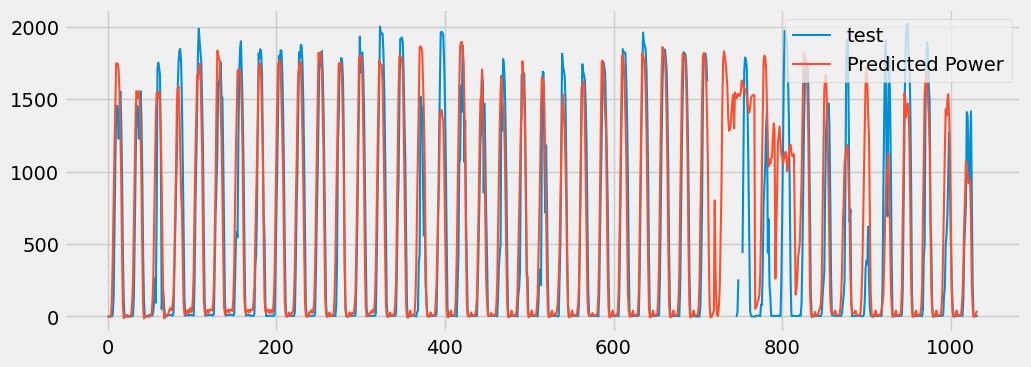

In [ ]:
# convert predictions to Series
pred_series = pd.Series(scaler.inverse_transform(pred).reshape(-1))
new_test = pd.Series(scaler.inverse_transform(data_test).reshape(-1))

# plot actual and predicted values
fig, ax = plt.subplots(figsize=(11, 4))
new_test.plot(ax=ax, label = 'test')
pred_series.plot(ax=ax, label='Predicted Power')
ax.legend();



In [ ]:
import plotly.graph_objs as go

# convert predictions to Series
pred_series = pd.Series(scaler.inverse_transform(pred).reshape(-1))
new_test = pd.Series(scaler.inverse_transform(data_test).reshape(-1))

# create a trace for actual power values
trace1 = go.Scatter(
    x = data_test.index,
    y = new_test,
    mode = 'lines',
    name = 'Actual Power'
)

# create a trace for predicted power values
trace2 = go.Scatter(
    x = data_test.index,
    y = pred_series,
    mode = 'lines',
    name = 'Predicted Power'
)


# define the layout of the plot
layout = go.Layout(
    title = 'Actual vs Predicted Power',
    xaxis = dict(title = 'Datetime'),
    yaxis = dict(title = 'Power (MW)'),
    hovermode = 'x unified'
)

# create the plot and show it
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()


# Xgboost = 0.02657032973924148
# LightGBM = 0.02243805529409426
# Catboost = 0.02821465793729185